# ARIMA Model (baseline model)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dotenv import load_dotenv
env_path = '../.env'
load_dotenv(dotenv_path=env_path)

True

## Import data

In [5]:
from electricity_price_predictor.data import get_shifted_price

In [6]:
df= get_shifted_price()
df.head()

price
time                      
2015-01-01 00:00:00  25.02
2015-01-01 01:00:00  18.29
2015-01-01 02:00:00  16.04
2015-01-01 03:00:00  14.60
2015-01-01 04:00:00  14.95

## Decomposition of hourly data

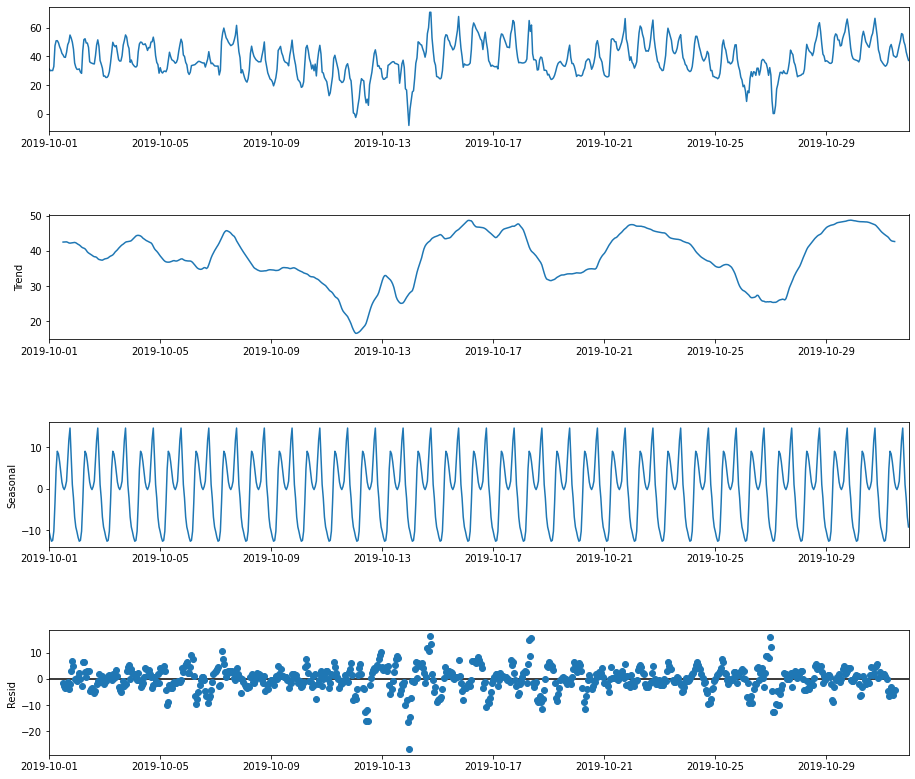

In [7]:
df_2019_10 = df[(df.index.year==2019) & (df.index.month==10)]
decompose_2019_10 = seasonal_decompose(df_2019_10, model='additive')
fig = decompose_2019_10.plot()
fig.set_size_inches(14, 12);

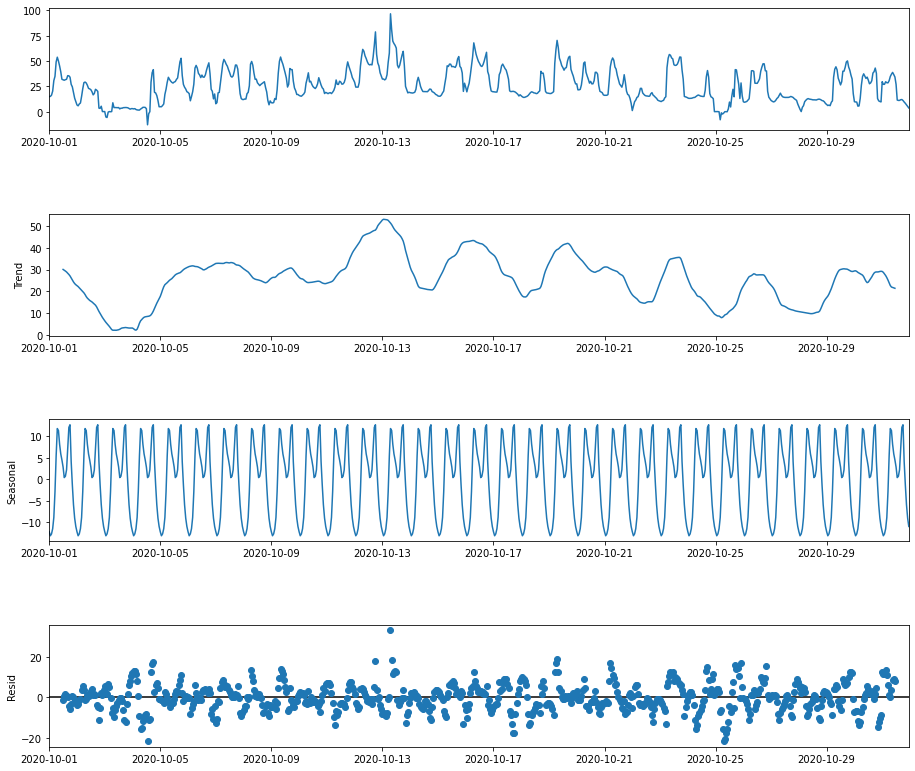

In [8]:
df_2020_10 = df[(df.index.year==2020) & (df.index.month==10)]
decompose_2020_10 = seasonal_decompose(df_2020_10, model='additive')
fig = decompose_2020_10.plot()
fig.set_size_inches(14, 12);

## Decomposition of df_hour_11

In [9]:
# get all the data for 11 am 
df_hour_11 = df[df.index.hour==11]
df_hour_11.head()

price
time                      
2015-01-01 11:00:00  16.08
2015-01-02 11:00:00  15.08
2015-01-03 11:00:00  22.31
2015-01-04 11:00:00  27.32
2015-01-05 11:00:00  40.97

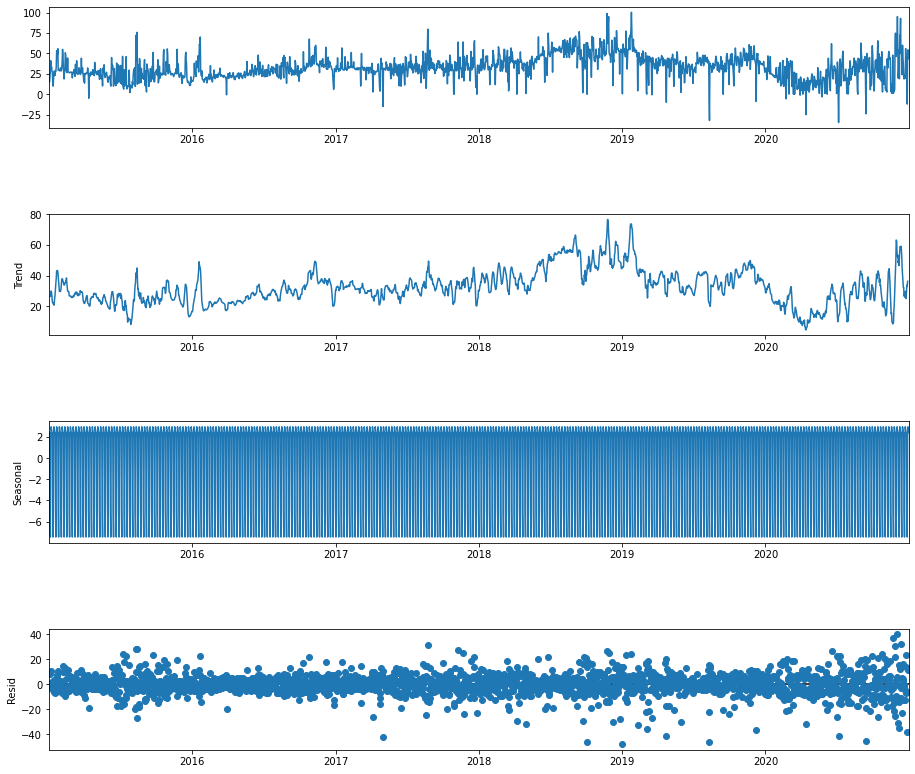

In [10]:
# for 5 years
decompose_5y = seasonal_decompose(df_hour_11, model='additive')
fig = decompose_5y.plot()
fig.set_size_inches(14, 12);

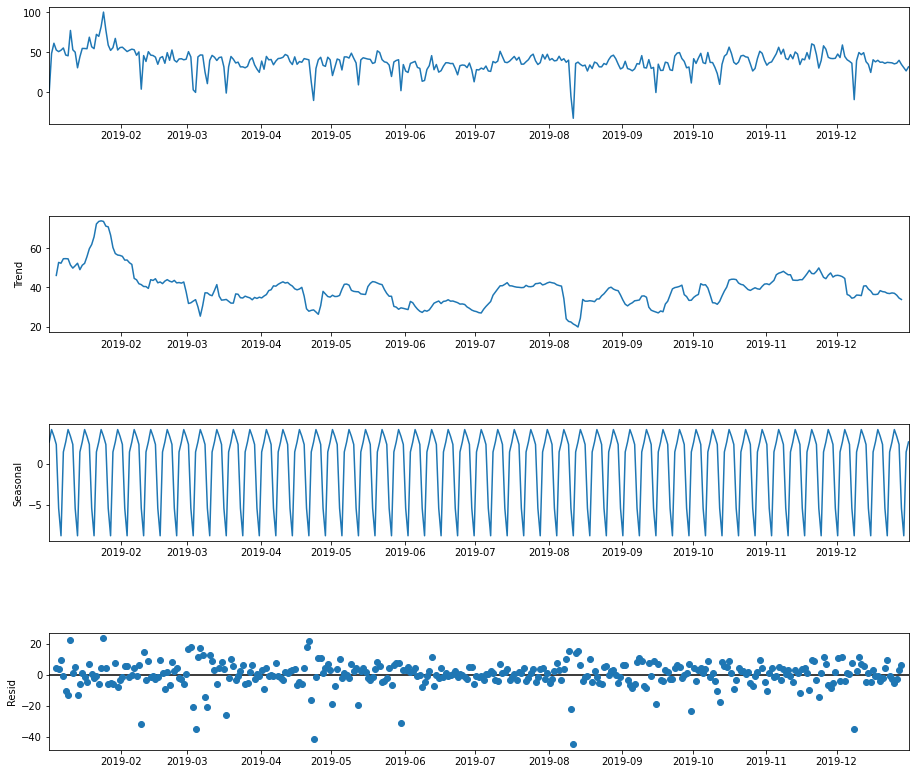

In [11]:
# for year 2019 
decompose_2019 = seasonal_decompose(df_hour_11[(df_hour_11.index.year==2019)], model='additive')
fig = decompose_2019.plot()
fig.set_size_inches(14, 12);

In [12]:
print('ADF of 2019 resid: ', adfuller(decompose_2019.resid.dropna())[1])

ADF of 2019 resid:  2.7343759413161596e-19


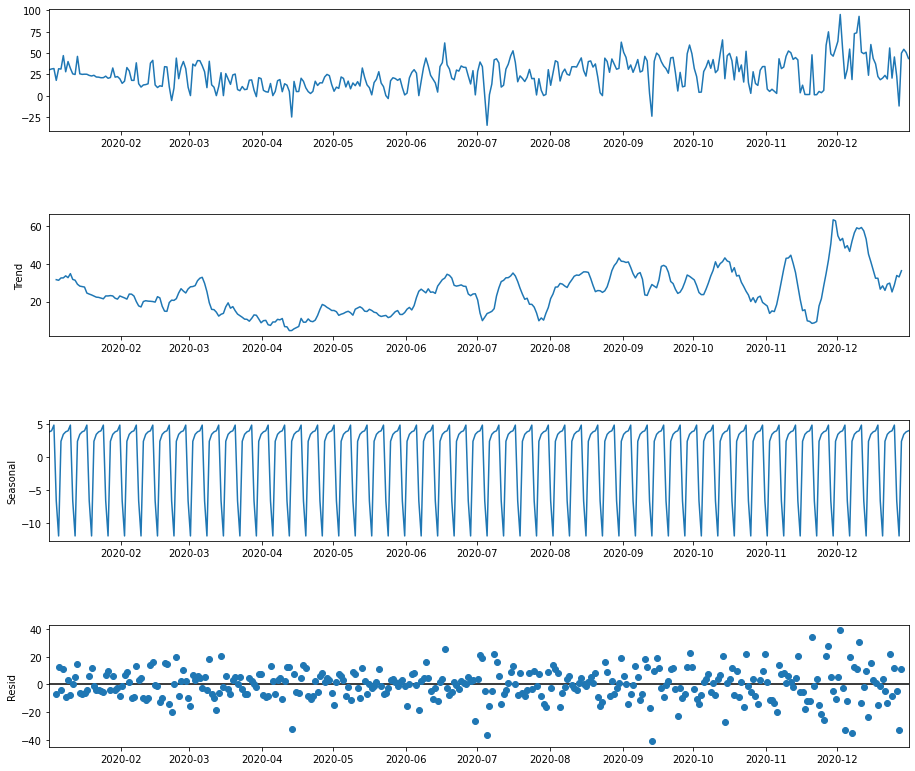

In [13]:
# for year 2020 
decompose_2020 = seasonal_decompose(df_hour_11[(df_hour_11.index.year==2020)], model='additive')
fig = decompose_2020.plot()
fig.set_size_inches(14, 12);

In [14]:
print('ADF of 2020 resid: ', adfuller(decompose_2020.resid.dropna())[1])

ADF of 2020 resid:  9.424820496611426e-18


- No clear monthly or yearly seasonality is observed.
- There is a clear weekly seasonality, which is likely caused by electricity usage in household

## Explore the stationarity

In [15]:
# remove the weekly seasonality
df_hour_11_deseasonalized = pd.DataFrame((df_hour_11.price - decompose_5y.seasonal), columns=['price'])

Text(0.5, 1.0, 'First order diff of deseasonalized series')

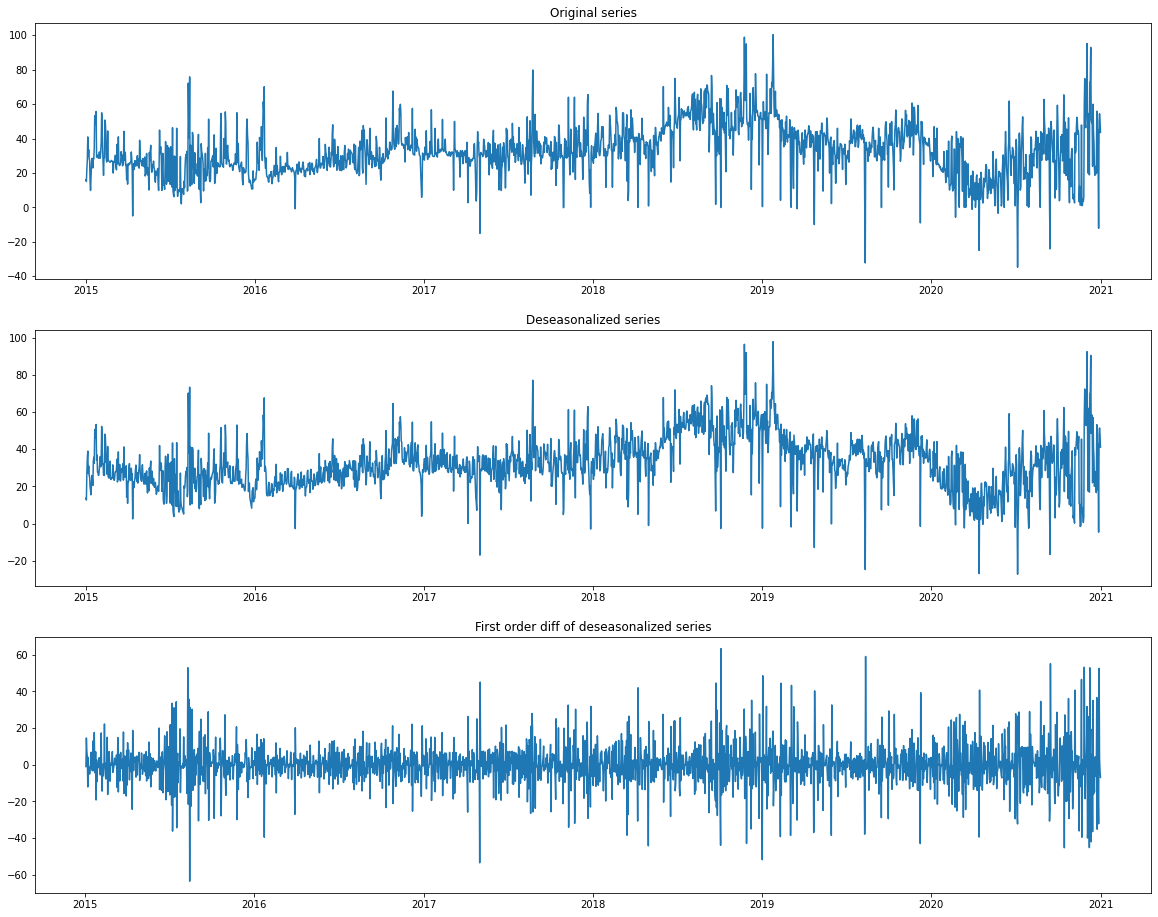

In [16]:
# Explore stationarity of deseasonalized data

fig, axs = plt.subplots(3, 1, figsize=(20,16))
# Original series
axs[0].plot(df_hour_11)
axs[0].set_title('Original series')

# Deseasonalized Series
axs[1].plot(df_hour_11_deseasonalized) 
axs[1].set_title('Deseasonalized series')

# Week + Normal differencing
axs[2].plot(df_hour_11_deseasonalized.diff(1))
axs[2].set_title('First order diff of deseasonalized series')

In [17]:
# ADF test
print('ADF of deseasonalized data: ', adfuller(df_hour_11_deseasonalized)[1])
print('ADF of first order diff deseasonalized data: ', adfuller(df_hour_11_deseasonalized.diff(1).dropna())[1])

ADF of deseasonalized data:  0.0028310833627632095
ADF of first order diff deseasonalized data:  2.7061689710114e-29


## Autocorrelation

### Original series

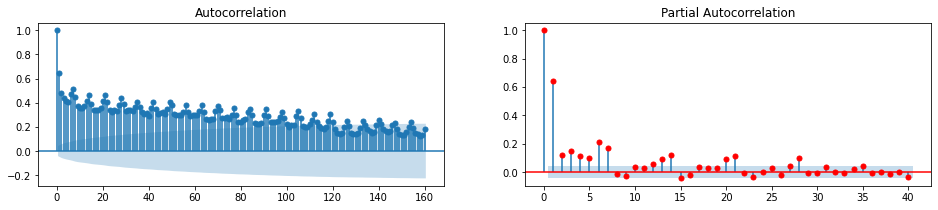

In [18]:
# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11, lags=160, ax=axes[0]);
plot_pacf(df_hour_11, lags=40, ax=axes[1], color='r');

- ACF shows weekly seasonality and one timepoint is correlated with pass 120 timepoints even more
- PACF also shows weekly seasonality

### After removing weekly seasonality

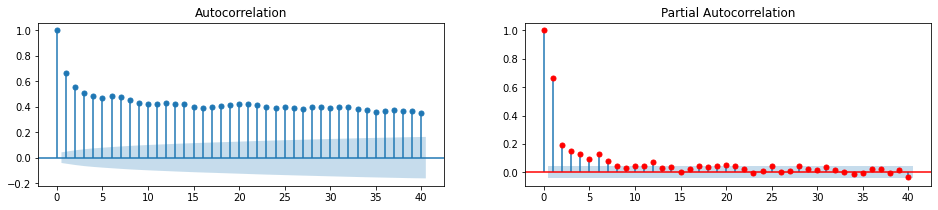

In [19]:
# ACF and PACF after removing weekly seasonality
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11_deseasonalized, lags=40, ax=axes[0]);
plot_pacf(df_hour_11_deseasonalized, lags=40, ax=axes[1], color='r');

- Both ACF show slow gradual decrease, should consider first order diff 

### After removing weekly seasonality and perform first order diff

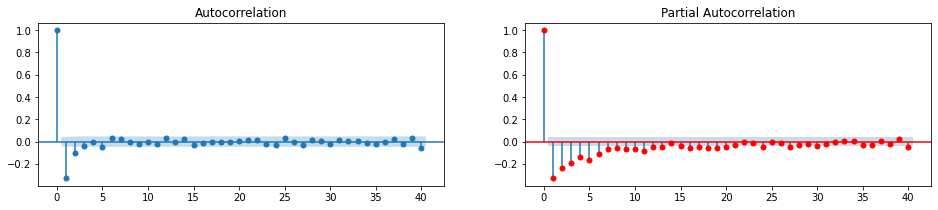

In [20]:
# ACF and PACF after removing weekly seasonality
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11_deseasonalized.diff(1).dropna(), lags=40, ax=axes[0]);
plot_pacf(df_hour_11_deseasonalized.diff(1).dropna(), lags=40, ax=axes[1], color='r');

- According to ACF and PACF, (p, d, q) = (1-7, 1, 1-2) 

## ARIMA model based on ACF and PACF

In [21]:
# grid search the hyper params
smodel = pm.auto_arima(df_hour_11_deseasonalized, seasonal=False, 
                       start_p=0, max_p=2, 
                       d=1,
                       start_q=0, max_q=2, 
                       trace=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16932.585, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16682.872, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16425.064, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16930.587, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16256.968, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16256.654, Time=1.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16559.073, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16258.862, Time=2.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16256.283, Time=1.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16291.314, Time=0.60 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16254.333, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=16289.341, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16255.014, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=16256.909, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0

In [22]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(df_hour_11_deseasonalized, order=(1,1,1), freq='D')
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                 2191
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8124.484
Method:                       css-mle   S.D. of innovations              9.864
Date:                Wed, 30 Dec 2020   AIC                          16256.968
Time:                        21:50:29   BIC                          16279.736
Sample:                    01-02-2015   HQIC                         16265.290
                         - 12-31-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0046      0.022      0.214      0.831      -0.038       0.047
ar.L1.D.price     0.3777      0.024     15.636      0.000       0.330       0.425
ma.L1.D.price    -0.9367      0.010    -89.242      0.000      -0.957      -0.916
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6479           +0.0000j            2.6479            0.0000
MA.1            1.0675           +0.0000j            1.0675            0.0000
-----------------------------------------------------------------------------
"""

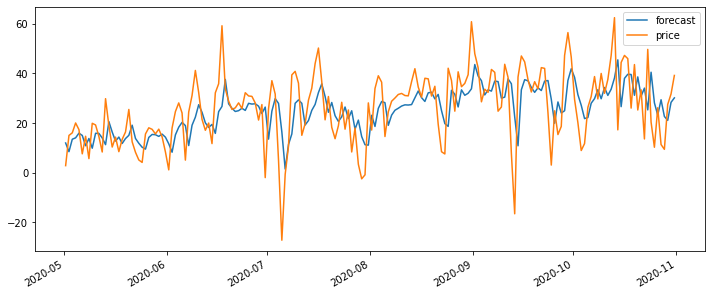

In [23]:
arima.plot_predict('2020-05', '2020-10')
fig = plt.gcf() 
fig.set_size_inches(12, 5);

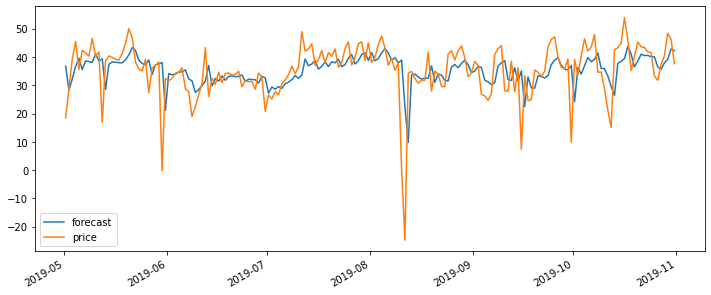

In [24]:
arima.plot_predict('2019-05', '2019-10')
fig = plt.gcf() 
fig.set_size_inches(12, 5);

## Evaluate the model

In [25]:
# Create a correct Training/Test split to predict the last 50 points
train = df_hour_11[df_hour_11.index <= '2019-10-22 11:00:00']
test = df_hour_11[(df_hour_11.index > '2019-10-22 11:00:00') & \
                  (df_hour_11.index < '2019-11-20 11:00:00')]

In [26]:
# Decomposition
decompose = seasonal_decompose(train, model='additive')
train_decompose = pd.DataFrame((train.price - decompose.seasonal), columns=['price'])

In [27]:
# Train the Model
arima = ARIMA(train_decompose, order=(1, 1, 1), freq='D')
arima = arima.fit()
# Forecast
forecast, std_err, confidence_int = arima.forecast(len(test), alpha=0.05)  # 95% confidence

In [28]:
# define a function for re-compose forecast and confident-intervals

def re_compose(forecast):
    '''take forecast price and confidence_intervals as input, returns re-composed forecast price and confident_int'''
    forecast = pd.DataFrame(forecast, index=test.index, columns=['price'])
    forecast['dayofweek'] = forecast.index.dayofweek
    # get the base price of day of week
    week_price = decompose.seasonal.to_frame().set_index(decompose.seasonal.index.dayofweek).drop_duplicates()
    # add the base price to the forecast price
    for i in range(7):
        value = week_price.loc[i, 'seasonal']
        forecast[forecast.dayofweek == i] = forecast[forecast.dayofweek == i] +value
        forecast['dayofweek'] = forecast.index.dayofweek
    forecast.drop(columns=['dayofweek'], inplace=True)
    return forecast    

In [29]:
# define a function for plotting the forecast

def plot_forecast(forecast, train, test, lower_int, upper_int, mape=None, mase=None):
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(forecast, label='forecast', color='orange')
    plt.fill_between(forecast.index, lower_int, upper_int, color='k', alpha=.15)
    title = 'Forecast vs Actuals'
    if isinstance(mape, str):
        title +=f' MAPE:{mape}'
    if isinstance(mase, str):
        title +=f' MASE:{mase}'
    plt.title(title)
    plt.legend(loc='upper left', fontsize=8);

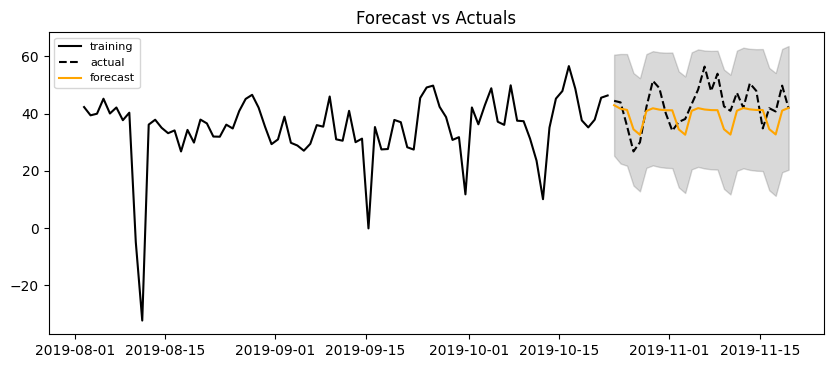

In [30]:
# plot the forecast
forecast = re_compose(forecast)
upper_int = re_compose(confidence_int[:, 1]).price
lower_int = re_compose(confidence_int[:, 0]).price
plot_forecast(forecast, train[train.index > '2019-08-1 11:00:00'], test, lower_int, upper_int)

In [31]:
# define a function for MAPE
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape = np.round(mape,2)
    return f'{mape}%' 

In [32]:
get_mape(test, forecast) # this was near 50% for2020

'13.75%'

In [33]:
# define a function for MASE
def get_mase(y_true, y_pred, train_y):
    y_true, y_pred, train_y = np.array(y_true), np.array(y_pred), np.array(train_y)
    upper = np.mean(np.abs(y_pred-y_true))
    train_t = train_y[:-1]
    train_t_1 = train_y[1:]
    lower = np.mean(np.abs(train_t-train_t_1))
    return upper/lower

In [34]:
get_mase(test, forecast, train.price)

0.814149943480385

## Check residuals for inference validity

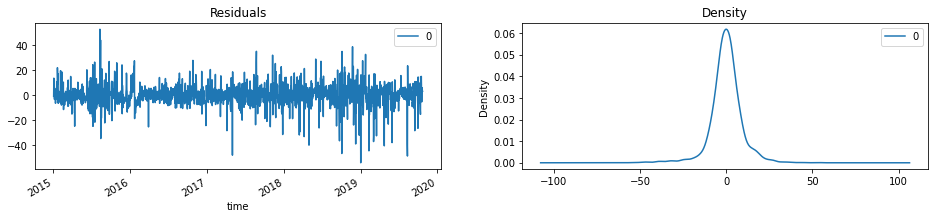

In [35]:
# check residuals for inference validity
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## SARIMA Model

In [36]:
# Grid search hyper params
smodel = pm.auto_arima(train, seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13516.708, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13323.649, Time=0.78 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13092.703, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13514.712, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13103.004, Time=0.31 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.30 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13075.461, Time=2.62 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.62 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13483.049, Time=1.39 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12907.006, Time=4.06 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12923.557, Time=2.08 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12800.216, Time=11.41 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=12798.448, Time=5.78 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=12918.156, Time=1.82 sec
 ARIMA(1,1,1)(2,0,1)[7] inter

In [37]:
# Build Model
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1,0,1,7), freq='D')
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = sarima.forecast(len(test), alpha=0.05)
confidence_int = results.conf_int()

c:\users\guli\.venvs\lewagon_project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


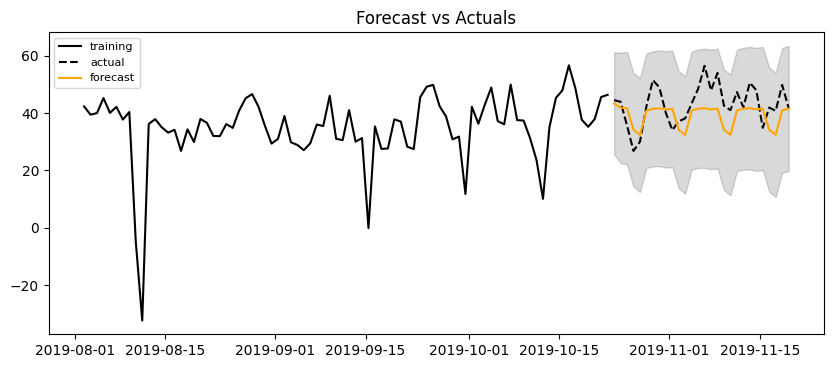

In [38]:
# plot the forecast
plot_forecast(forecast, 
              train[train.index > '2019-08-1 11:00:00'], 
              test, 
              confidence_int['lower price'],
              confidence_int['upper price'])

In [39]:
get_mape(test, forecast)

'16.11%'

## Walk forward validation

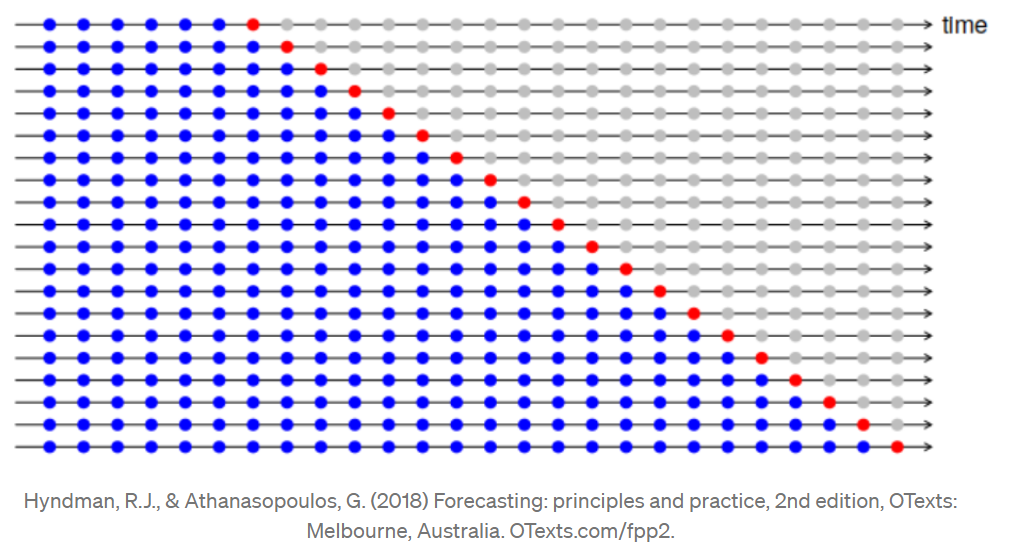

In [46]:
from electricity_price_predictor.sarima import train_sarimax, get_daily_price
from electricity_price_predictor.plot import plot_evaluation

In [47]:
data = get_daily_price(hour=11)

### 2019-10-22 >> 2019-11-21

In [43]:
# 2019-10-22 + 30 days
train, test, mape, mase = train_sarimax(data=data, exog=False, hour=11, split_date = '2019-10-22 11:00:00', n=30)

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

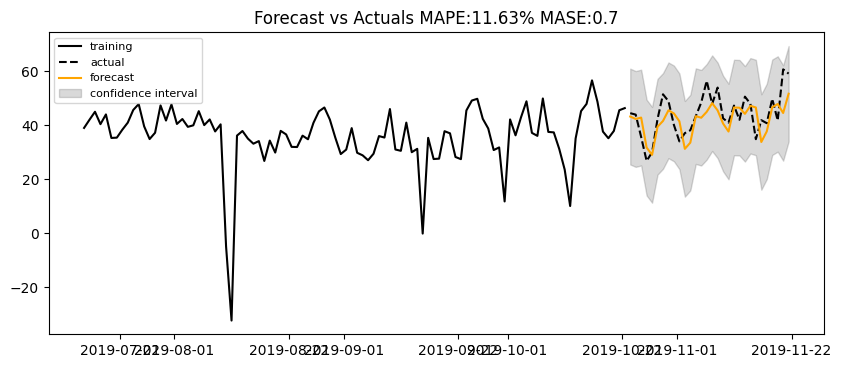

In [44]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

### 2019-11-22 >> 2019-12-21

In [48]:
# 2019-11-22 + 30 days
train, test, mape, mase = train_sarimax(data=data, exog=False, hour=11, split_date = '2019-11-22 11:00:00', n=30)

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

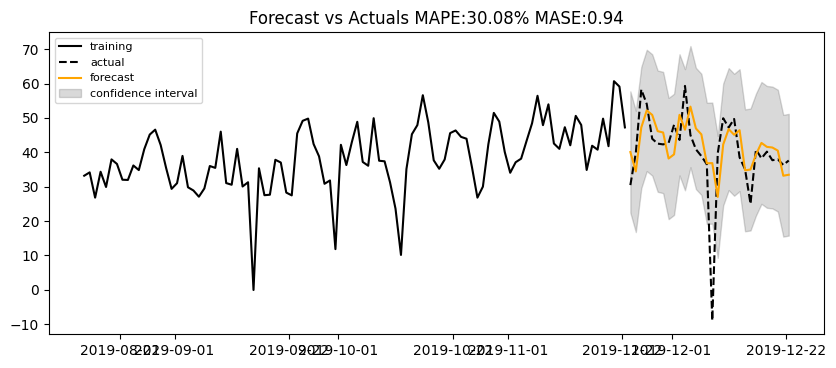

In [50]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

### 2019-08-30 >> 2020-03-01

In [108]:
# evaluate the sarima model for test_set(2019-8-30 till 2020-03-01)
train, test, mape, mase = train_sarimax(data=data, exog=False, hour=11, split_date = '2019-8-30 11:00:00', n=184)

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

################# forecasting for day 120 ##################
################# forecasting for day 121 ##################
################# forecasting for day 122 ##################
################# forecasting for day 123 ##################
################# forecasting for day 124 ##################
################# forecasting for day 125 ##################
################# forecasting for day 126 ##################
################# forecasting for day 127 ##################
################# forecasting for day 128 ##################
################# forecasting for day 129 ##################
################# forecasting for day 130 ##################
################# forecasting for day 131 ##################
################# forecasting for day 132 ##################
################# forecasting for day 133 ##################
################# forecasting for day 134 ##################
################# forecasting for day 135 ##################
################# foreca

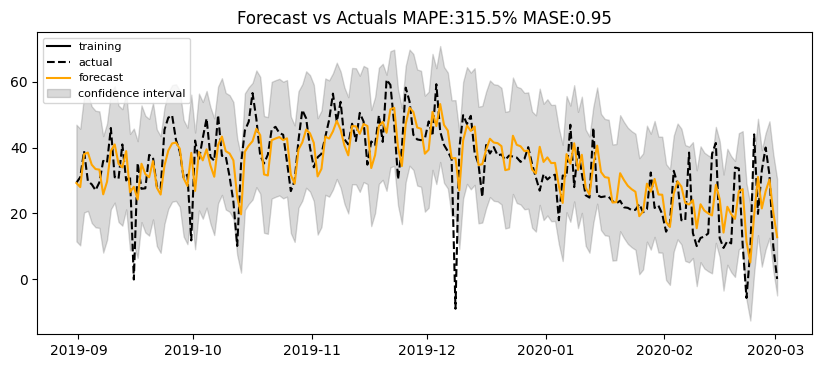

In [112]:
plot_evaluation(train.iloc[-1:], test, mape=mape, mase=mase)

- As shown in the plot, our SARIMA model can capture most of the patterns but it failed to capture the sudden drops.
- To capture the sudden drops, exogenous features need to be included.
- Now, what could cause negative electricity price??

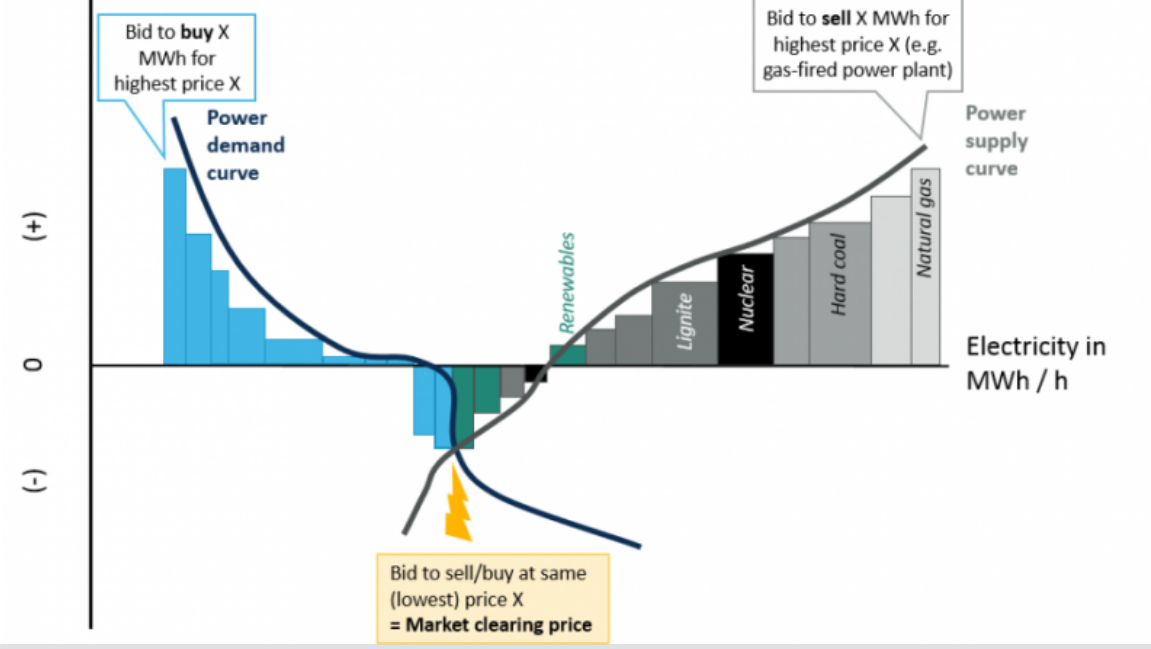

After doing some research, I found that strong wind generation often cause negative power price in DK.

# SARIMAX Model
Here, I will explore some exogenous features and build sarimax model 

## Import data

In [51]:
from electricity_price_predictor.archive import get_daily_data

In [53]:
df = get_daily_data(hour=11)
df.head()

price    load      temp   humidity  wind_speed  \
2015-11-25 11:00:00  36.90  3035.0  5.077536  95.815513    2.584760   
2015-11-26 11:00:00  37.17  3044.0  4.019904  85.208496    2.299718   
2015-11-27 11:00:00  23.63  2966.0  7.824089  93.253765    7.014387   
2015-11-28 11:00:00  22.14  2334.0  5.257447  87.268743    4.490272   
2015-11-29 11:00:00  20.76  2261.0  5.943119  82.674656    7.507253   

                      total_prod    wind_prod  wind_share  coal_price  \
2015-11-25 11:00:00  2466.695125   261.533098    0.106026       46.05   
2015-11-26 11:00:00  2573.865875   243.890235    0.094756       46.35   
2015-11-27 11:00:00  3729.922374  2568.699902    0.688674       46.45   
2015-11-28 11:00:00  2822.151194  1604.427656    0.568512       46.45   
2015-11-29 11:00:00  3432.506703  2419.205434    0.704793       46.45   

                     holiday  weekend  
2015-11-25 11:00:00        0        0  
2015-11-26 11:00:00        0        0  
2015-11-27 11:00:00        0        0  
2015-11-28 11:00:00        0        1  
2015-11-29 11:00:00        0        1

## Explore exogenous features

### Compare the trend of price to trends of exog features

Text(0, 0.5, 'coal_price')

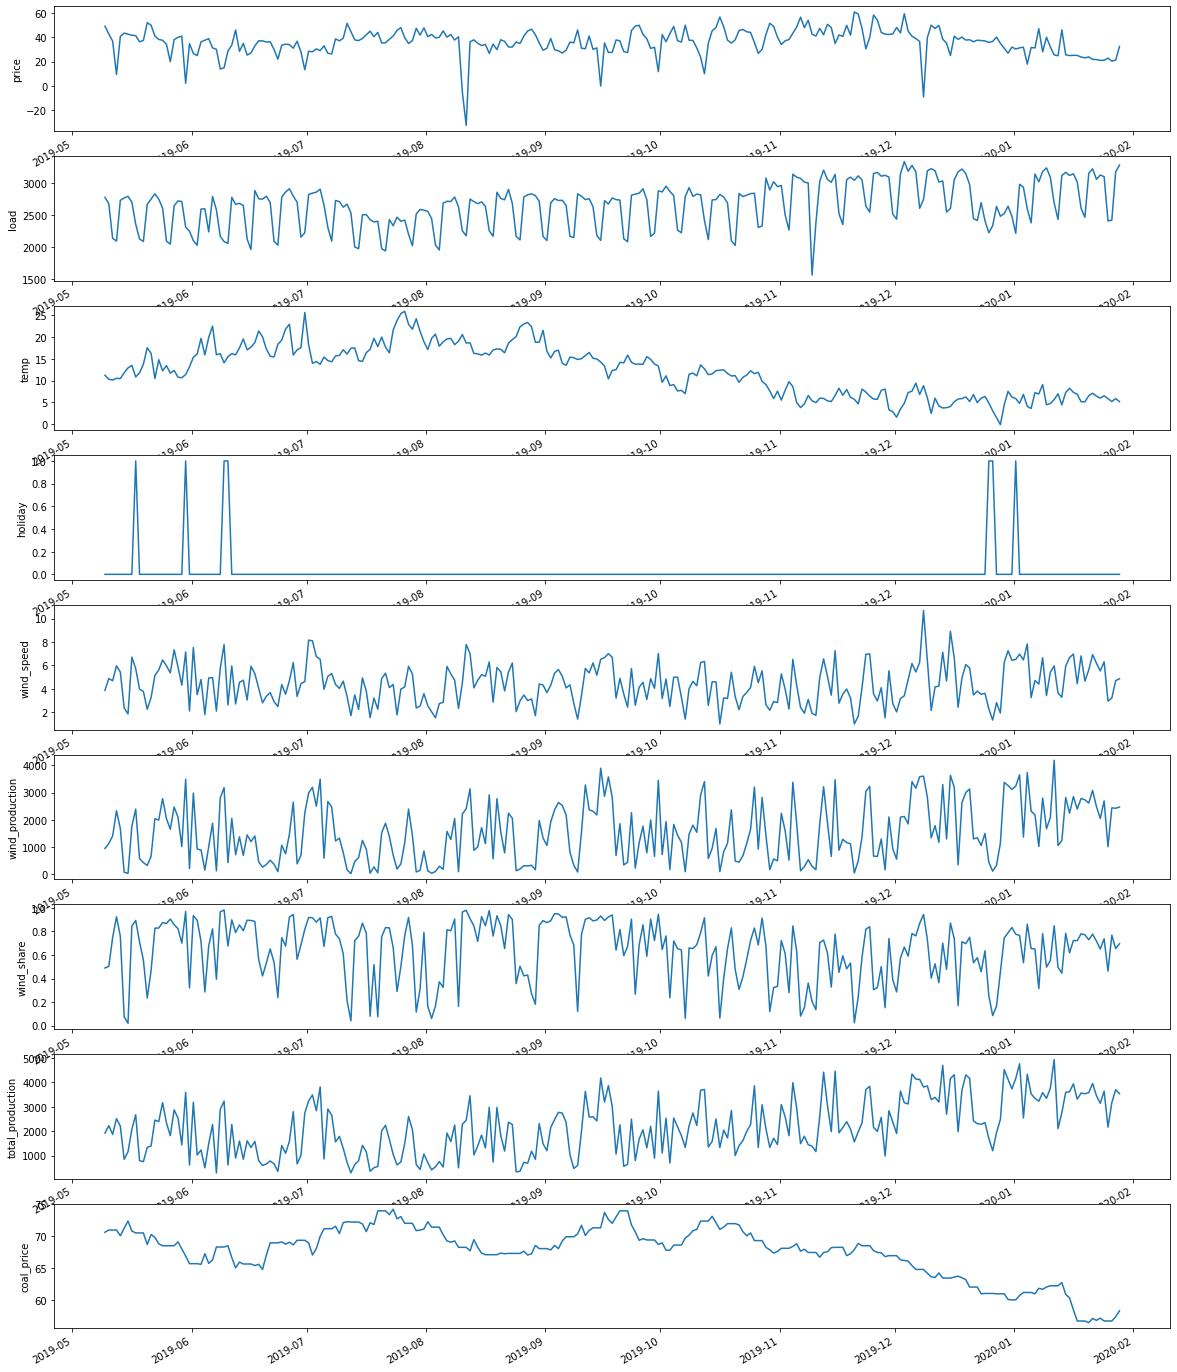

In [54]:
fig, ax = plt.subplots(9,1, figsize=(20,27))
df.price[-560:-295].plot(ax=ax[0])
ax[0].set_ylabel('price')
df.load[-560:-295].plot(ax=ax[1])
ax[1].set_ylabel('load')
df.temp[-560:-295].plot(ax=ax[2])
ax[2].set_ylabel('temp')
df.holiday[-560:-295].plot(ax=ax[3])
ax[3].set_ylabel('holiday')
df.wind_speed[-560:-295].plot(ax=ax[4])
ax[4].set_ylabel('wind_speed')
df.wind_prod[-560:-295].plot(ax=ax[5])
ax[5].set_ylabel('wind_production')
df.wind_share[-560:-295].plot(ax=ax[6])
ax[6].set_ylabel('wind_share')
df.total_prod[-560:-295].plot(ax=ax[7])
ax[7].set_ylabel('total_production')
df.coal_price[-560:-295].plot(ax=ax[8])
ax[8].set_ylabel('coal_price')

- total production highly depends on wind production and wind production highly depends on **wind_speed**
- **holidays** seems to have impact on price
- need further decomposition for temp and load

### Decompose and Compare 

In [55]:
# decompose price and load
tmp = df.dropna()
decompose_price = seasonal_decompose(tmp['price'], model='additive')
decompose_load = seasonal_decompose(tmp['load'], model='additive')
decompose_temp = seasonal_decompose(tmp['temp'], model='additive')
decompose_wind_speed = seasonal_decompose(tmp['wind_speed'], model='additive')
decompose_wind_production = seasonal_decompose(tmp['wind_prod'], model='additive')
decompose_production = seasonal_decompose(tmp['total_prod'], model='additive')
decompose_holiday = seasonal_decompose(tmp['holiday'], model='additive')
decompose_coal = seasonal_decompose(tmp['coal_price'], model='additive')

**Trends in 5 years**

Text(0, 0.5, 'coal_price')

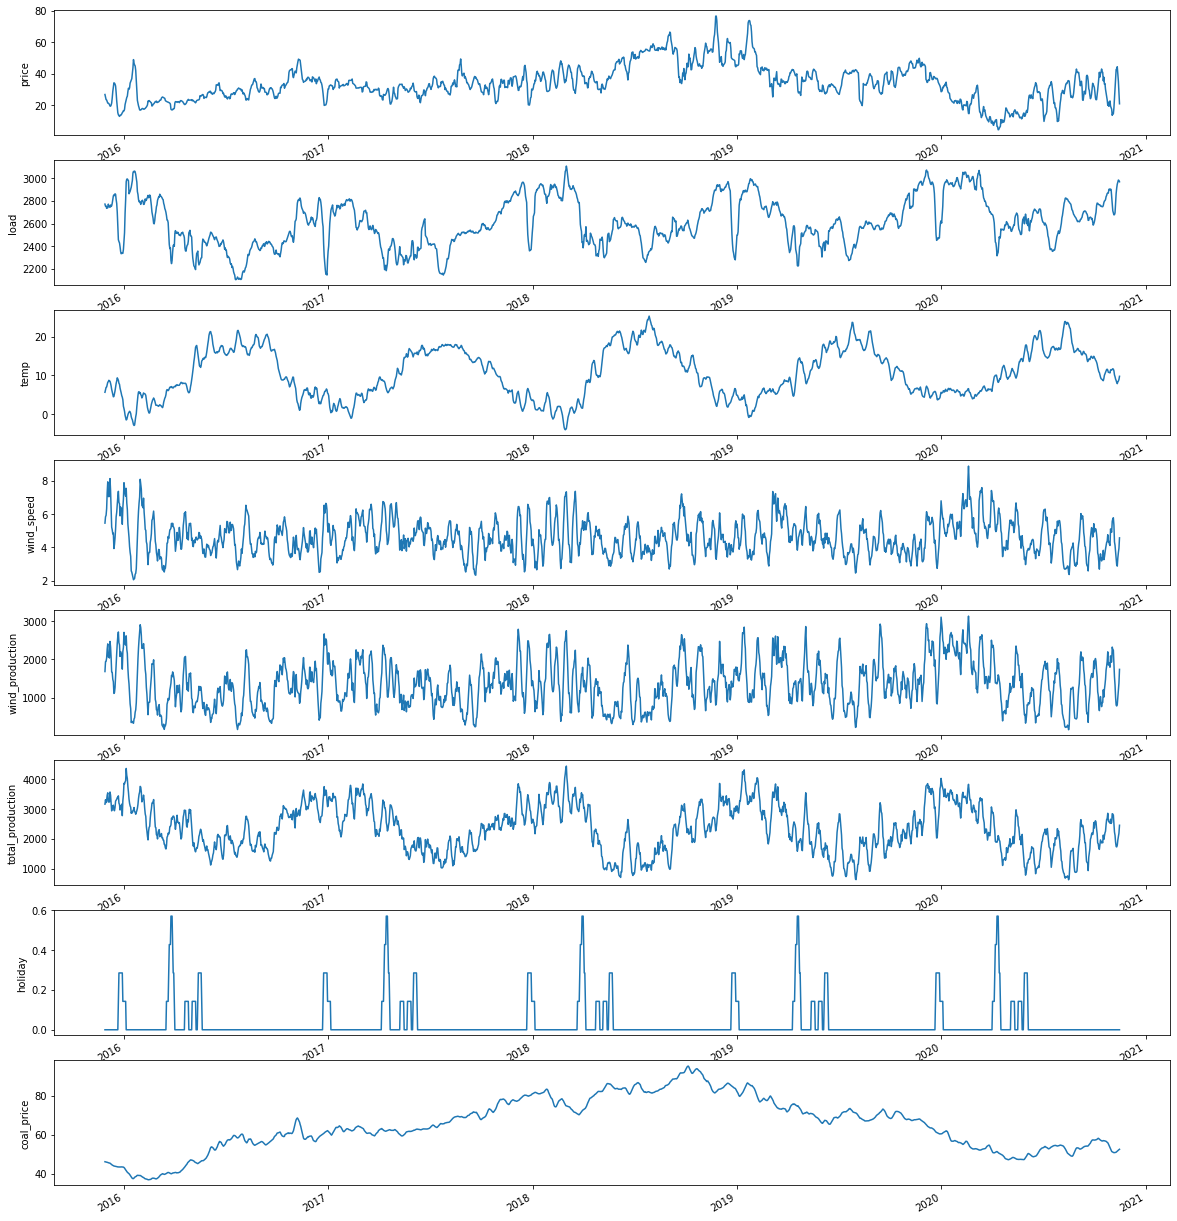

In [56]:
# compre the trends of all the above features
fig, ax = plt.subplots(8,1, figsize=(20,24))
decompose_price.trend.plot(ax=ax[0])
ax[0].set_ylabel('price')
decompose_load.trend.plot(ax=ax[1])
ax[1].set_ylabel('load')
decompose_temp.trend.plot(ax=ax[2])
ax[2].set_ylabel('temp')
decompose_wind_speed.trend.plot(ax=ax[3])
ax[3].set_ylabel('wind_speed')
decompose_wind_production.trend.plot(ax=ax[4])
ax[4].set_ylabel('wind_production')
decompose_production.trend.plot(ax=ax[5])
ax[5].set_ylabel('total_production')
decompose_holiday.trend.plot(ax=ax[6])
ax[6].set_ylabel('holiday')
decompose_coal.trend.plot(ax=ax[7])
ax[7].set_ylabel('coal_price')

- Load, temp and total production have clear seasonal seasonality

**Trends in 2019**

Text(0, 0.5, 'coal_price')

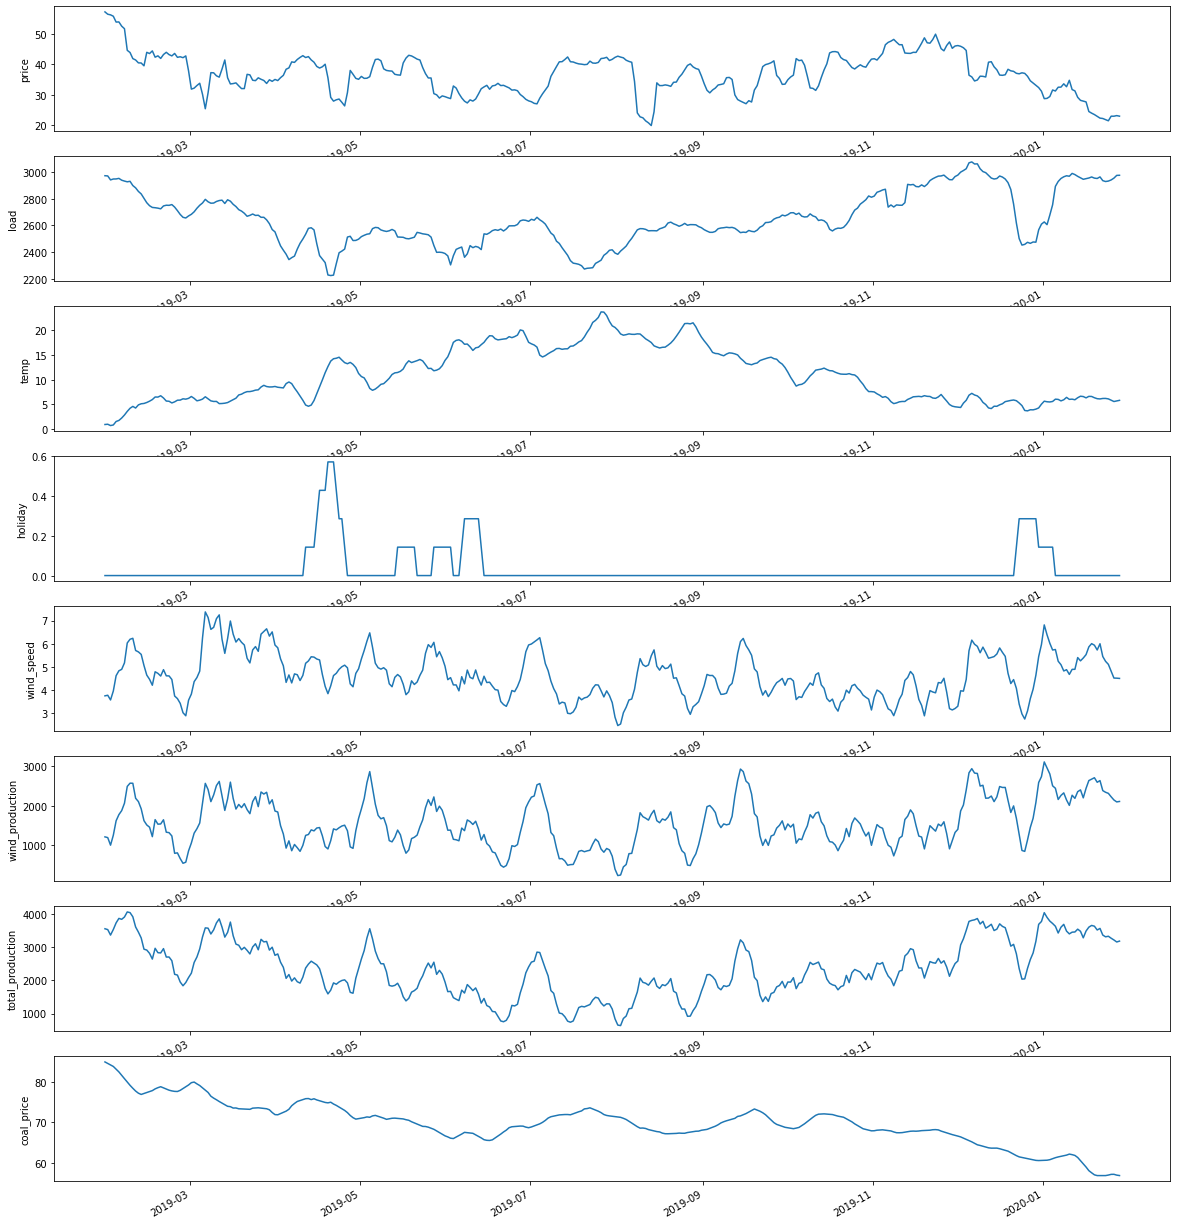

In [57]:
# compare the trends of all the above features 2019
fig, ax = plt.subplots(8,1, figsize=(20,24))
decompose_price.trend[-660:-295].plot(ax=ax[0])
ax[0].set_ylabel('price')
decompose_load.trend[-660:-295].plot(ax=ax[1])
ax[1].set_ylabel('load')
decompose_temp.trend[-660:-295].plot(ax=ax[2])
ax[2].set_ylabel('temp')
decompose_holiday.trend[-660:-295].plot(ax=ax[3])
ax[3].set_ylabel('holiday')
decompose_wind_speed.trend[-660:-295].plot(ax=ax[4])
ax[4].set_ylabel('wind_speed')
decompose_wind_production.trend[-660:-295].plot(ax=ax[5])
ax[5].set_ylabel('wind_production')
decompose_production.trend[-660:-295].plot(ax=ax[6])
ax[6].set_ylabel('total_production')
decompose_coal.trend[-660:-295].plot(ax=ax[7])
ax[7].set_ylabel('coal_price')

- part of price trend can be captured by load 

**Residuals in 2019**

Text(0, 0.5, 'coal_price')

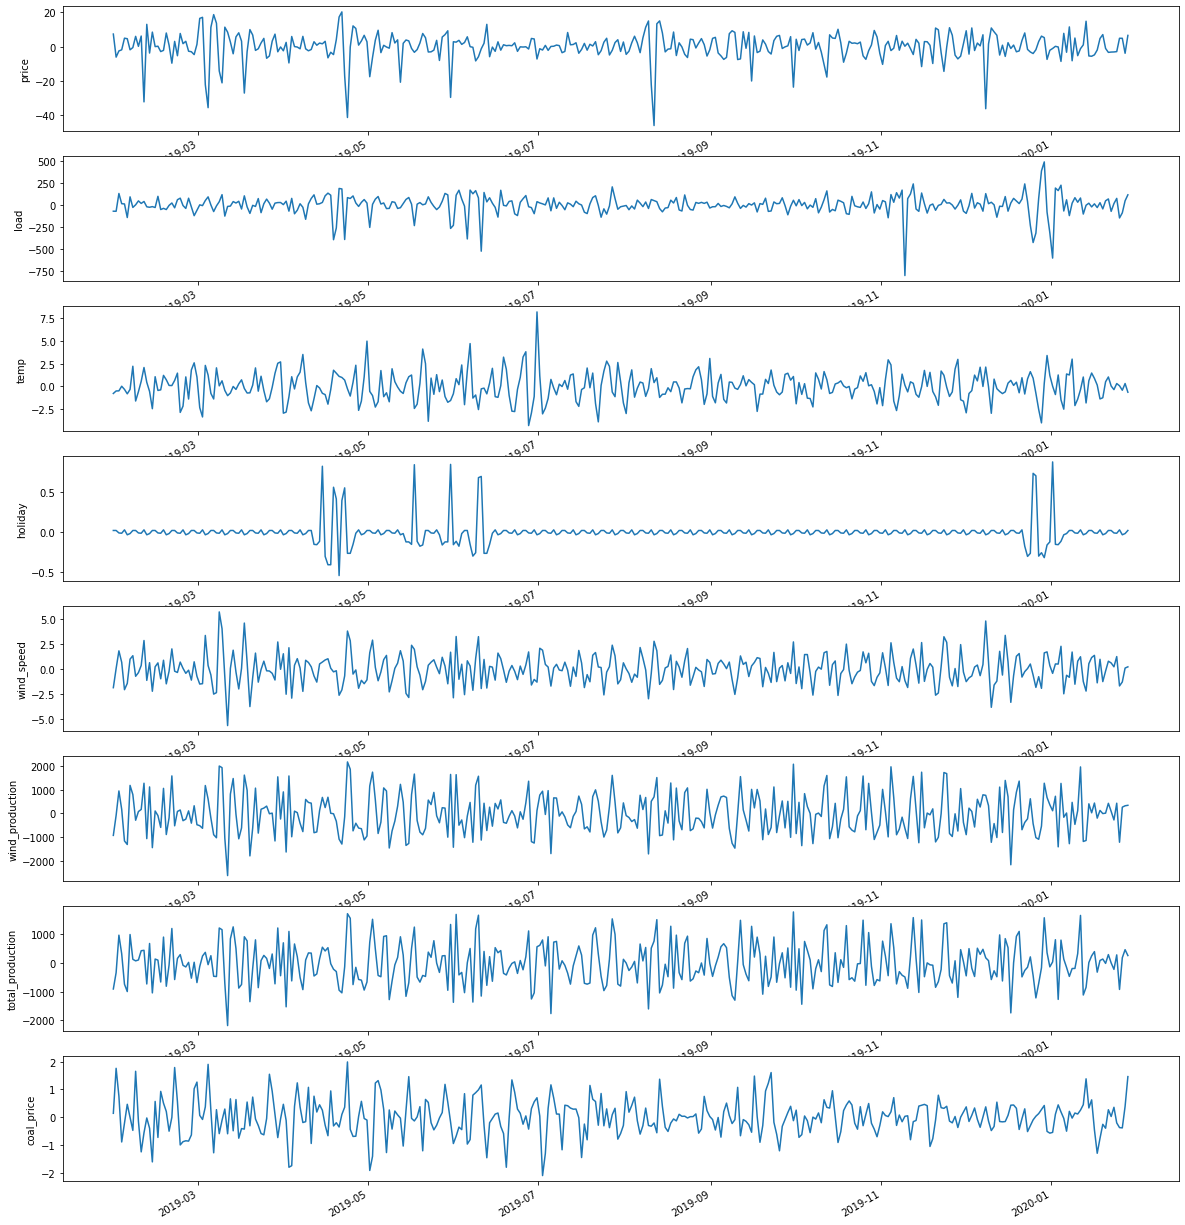

In [58]:
# compre the residuals of all the above features
fig, ax = plt.subplots(8,1, figsize=(20,24))
decompose_price.resid[-660:-295].plot(ax=ax[0])
ax[0].set_ylabel('price')
decompose_load.resid[-660:-295].plot(ax=ax[1])
ax[1].set_ylabel('load')
decompose_temp.resid[-660:-295].plot(ax=ax[2])
ax[2].set_ylabel('temp')
decompose_holiday.resid[-660:-295].plot(ax=ax[3])
ax[3].set_ylabel('holiday')
decompose_wind_speed.resid[-660:-295].plot(ax=ax[4])
ax[4].set_ylabel('wind_speed')
decompose_wind_production.resid[-660:-295].plot(ax=ax[5])
ax[5].set_ylabel('wind_production')
decompose_production.resid[-660:-295].plot(ax=ax[6])
ax[6].set_ylabel('total_production')
decompose_coal.resid[-660:-295].plot(ax=ax[7])
ax[7].set_ylabel('coal_price')

## Select exogenous features

I will add one exogenous feature at a time and check whether MAPE and MASE reduce after adding that exogenous feature.                       

MAPE and MASE will be calculated based on the forecast for the following periods:(2019-10-22+30days)/(2019-12-22+30days)

### Without exogenous feature

In [59]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10941.536, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10801.338, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10631.829, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10939.536, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10640.382, Time=0.24 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10613.929, Time=2.01 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.15 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=10910.016, Time=1.16 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10463.141, Time=3.88 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10479.503, Time=1.61 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=10372.597, Time=8.28 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=10369.769, Time=4.62 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10474.641, Time=1.42 sec
 ARIMA(1,1,1)(2,0,1)[7] interce

In [43]:
# 2019-10-22 + 30 days
train, test, mape, mase = train_sarimax(data=data, exog=False, hour=11, 
                                        split_date = '2019-10-22 11:00:00', n=30)

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

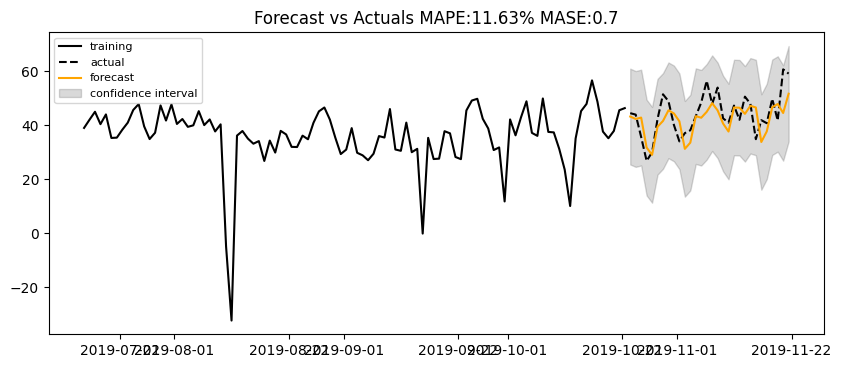

In [44]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

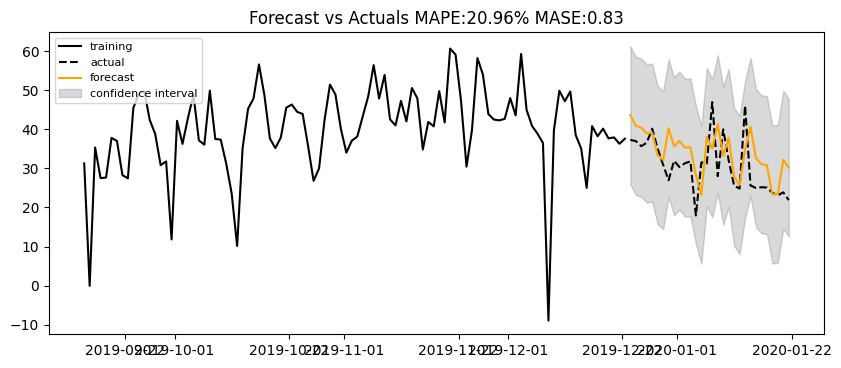

In [60]:
# 2019-12-22 + 30 days ARIMA(1,1,1)(1,0,2)[7] intercept
train, test, mape, mase = train_sarimax(data=data, exog=False, hour=11, split_date = '2019-12-22 11:00:00', n=30)
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

### Load as exogenous feature

In [61]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.load,
                       seasonal=True, m=7, 
                       start_p=0, max_p=1, start_q=0, max_q=1,
                       start_P=0, max_P=1, start_Q=0, max_Q=1, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10941.536, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10801.338, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10631.829, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10939.536, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10640.382, Time=0.24 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.64 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=10629.053, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=10926.435, Time=0.30 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10474.641, Time=1.38 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=10496.259, Time=0.64 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=10369.769, Time=4.56 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10479.503, Time=1.62 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(1,1,1)(1,0,1)[7]             :

In [68]:
train, test, mape, mase = \
train_sarimax(data=df, exog=('load', (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

c:\users\guli\.venvs\lewagon_project\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


################# forecasting for day 24 ##################
################# forecasting for day 25 ##################
################# forecasting for day 26 ##################
################# forecasting for day 27 ##################
################# forecasting for day 28 ##################
################# forecasting for day 29 ##################
################# forecasting for day 30 ##################


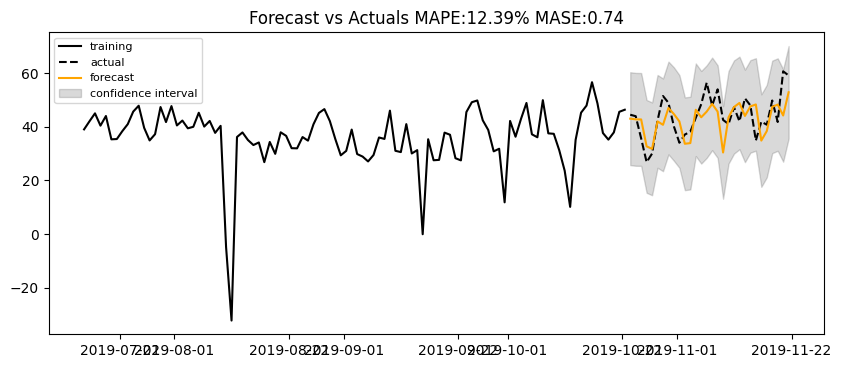

In [69]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

### Wind_speed as exogenous feature

In [70]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.wind_speed,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10941.536, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10801.338, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10631.829, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10939.536, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10640.382, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10613.929, Time=1.98 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.26 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=10910.016, Time=1.16 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10463.141, Time=3.86 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10479.503, Time=1.56 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=10372.597, Time=8.16 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=10369.769, Time=4.59 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10474.641, Time=1.38 sec
 ARIMA(1,1,1)(2,0,1)[7] interce

In [72]:
train, test, mape, mase = \
train_sarimax(data=df, exog=('wind_speed', (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

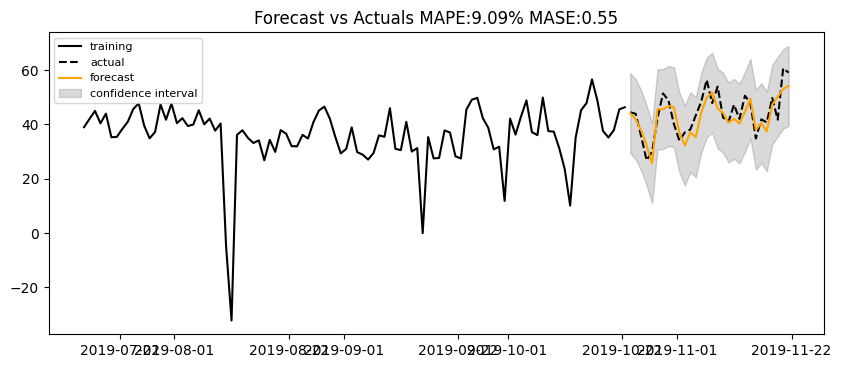

In [73]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

### Holiday as exogenous feature

In [74]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.holiday,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10941.536, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10801.338, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10631.829, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10939.536, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10640.382, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.64 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10613.929, Time=2.05 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.39 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=10910.016, Time=1.13 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10463.141, Time=3.95 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10479.503, Time=1.69 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=10372.597, Time=8.50 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=10369.769, Time=4.75 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10474.641, Time=1.41 sec
 ARIMA(1,1,1)(2,0,1)[7] interce

In [75]:
train, test, mape, mase = \
train_sarimax(data=df, split_date='2019-12-22 11:00:00', exog=('holiday', (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

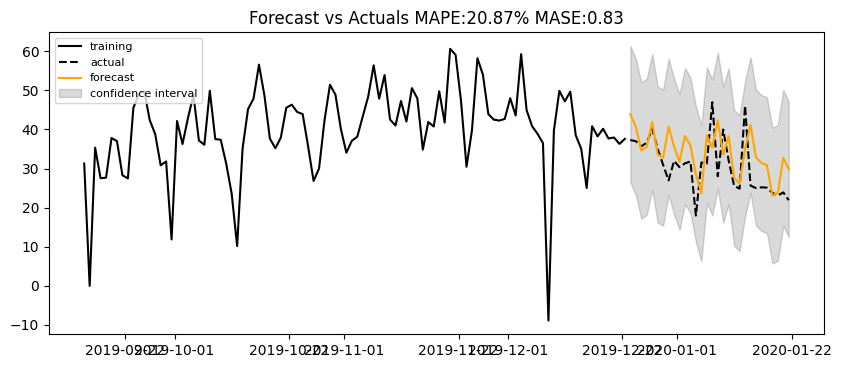

In [76]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

### Holiday and dayofweek as exogenous feature

In [77]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train[['holiday','weekend']],
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10941.536, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10801.338, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10631.829, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10939.536, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10640.382, Time=0.24 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.65 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10613.929, Time=1.99 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.33 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=10910.016, Time=1.15 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10463.141, Time=3.87 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10479.503, Time=1.62 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=10372.597, Time=8.22 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=10369.769, Time=4.58 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10474.641, Time=1.37 sec
 ARIMA(1,1,1)(2,0,1)[7] interce

In [79]:
train, test, mape, mase = \
train_sarimax(data=df, split_date='2019-12-22 11:00:00', exog=(['holiday','weekend'], (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

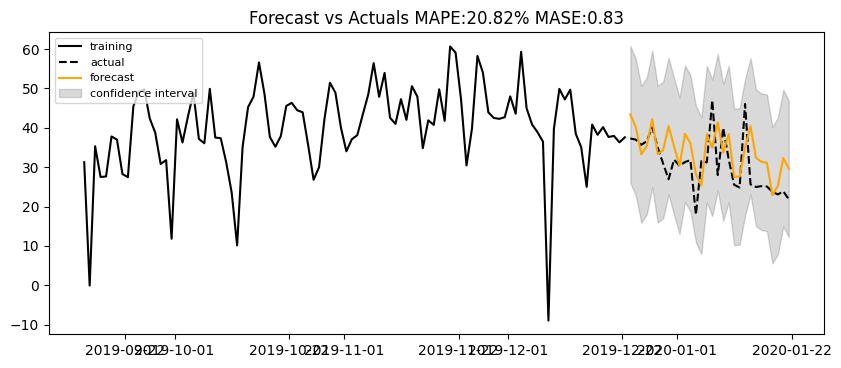

In [80]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

### Temperature as exogenous feature

In [87]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.temp,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10941.536, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10801.338, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10631.829, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10939.536, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10640.382, Time=0.25 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.79 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10613.929, Time=2.14 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.15 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=10910.016, Time=1.16 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10463.141, Time=3.93 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10479.503, Time=1.63 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=10372.597, Time=8.39 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=10369.769, Time=4.73 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10474.641, Time=1.43 sec
 ARIMA(1,1,1)(2,0,1)[7] interce

In [91]:
train, test, mape, mase = \
train_sarimax(data=df, split_date='2019-10-22 11:00:00', exog=('temp', (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

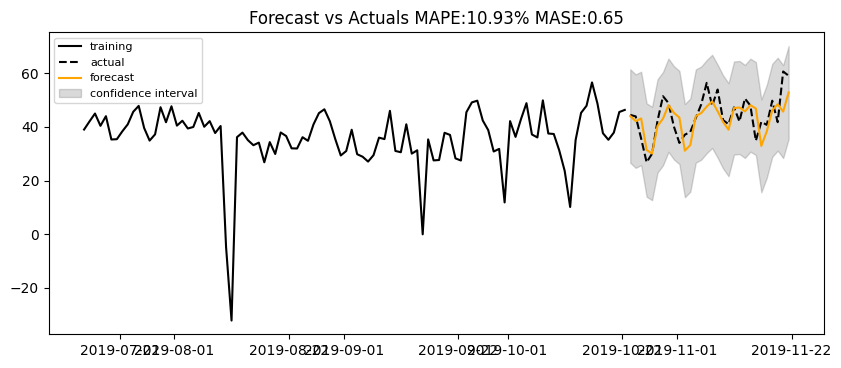

In [92]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

###  Humidity as exogenous feature

In [88]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.humidity,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10941.536, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10801.338, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10631.829, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10939.536, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10640.382, Time=0.25 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.71 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10613.929, Time=2.06 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.01 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=10910.016, Time=1.17 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10463.141, Time=3.82 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10479.503, Time=1.59 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=10372.597, Time=8.20 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=10369.769, Time=4.70 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10474.641, Time=1.41 sec
 ARIMA(1,1,1)(2,0,1)[7] interce

In [93]:
train, test, mape, mase = \
train_sarimax(data=df, split_date='2019-10-22 11:00:00', exog=('humidity', (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

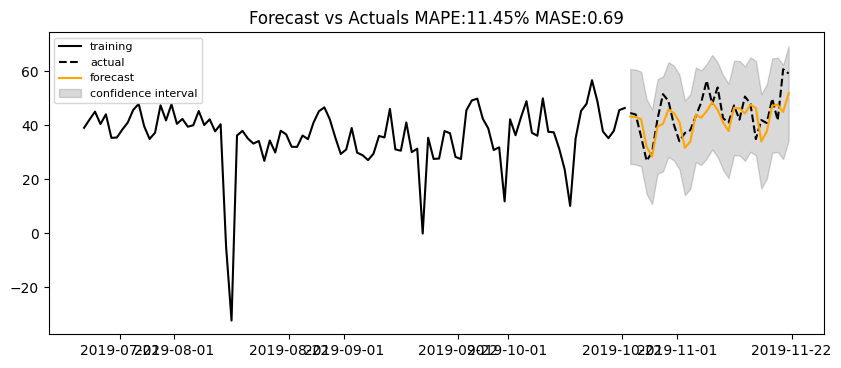

In [94]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

###  Coal_price as exogenous feature

In [95]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.coal_price,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10941.536, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10801.338, Time=0.62 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10631.829, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10939.536, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10640.382, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.62 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10613.929, Time=2.00 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.02 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=10910.016, Time=1.19 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10463.141, Time=3.79 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10479.503, Time=1.55 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=10372.597, Time=8.03 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=10369.769, Time=4.63 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10474.641, Time=1.37 sec
 ARIMA(1,1,1)(2,0,1)[7] interce

In [96]:
train, test, mape, mase = \
train_sarimax(data=df, split_date='2019-10-22 11:00:00', exog=('coal_price', (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

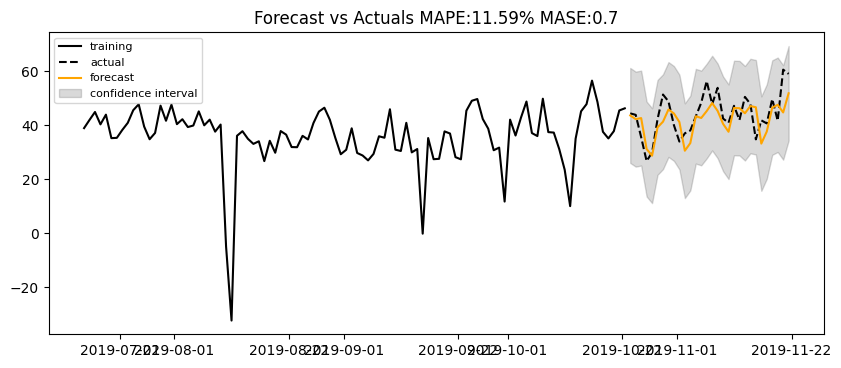

In [97]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

## Build Sarimax

- Features to include: **wind_speed, holidays, whether it is weekend, temp, humidity**
- Features to drop: load, total_prod, wind_prod, wind_share, clouds_all, coal_price

In [98]:
df = df[['price', 'wind_speed', 'holiday', 'weekend', 'temp', 'humidity']]

In [99]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train[['wind_speed', 'holiday', 'weekend', 'temp', 'humidity']],
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=10941.536, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=10801.338, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10631.829, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=10939.536, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10640.382, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10613.929, Time=2.01 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.14 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=10910.016, Time=1.14 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10463.141, Time=3.78 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10479.503, Time=1.59 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=10372.597, Time=8.04 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=10369.769, Time=4.55 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=10474.641, Time=1.36 sec
 ARIMA(1,1,1)(2,0,1)[7] interce

In [100]:
train, test, mape, mase = \
train_sarimax(data=df, split_date = '2019-10-22 11:00:00', 
              exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

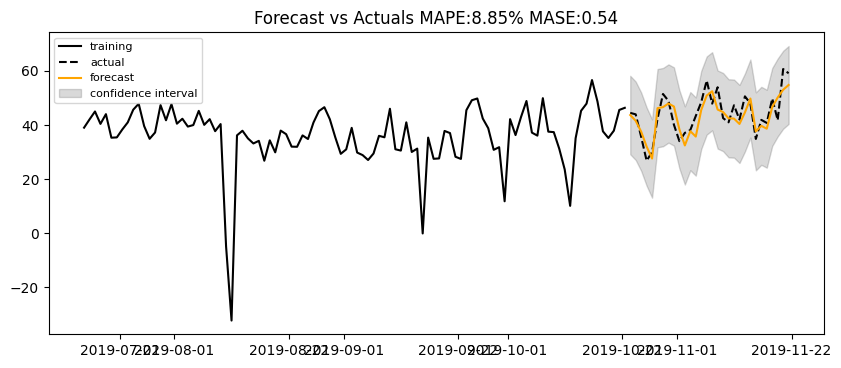

In [102]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

In [103]:
train, test, mape, mase = \
train_sarimax(data=df, split_date = '2019-11-22 11:00:00', 
             exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

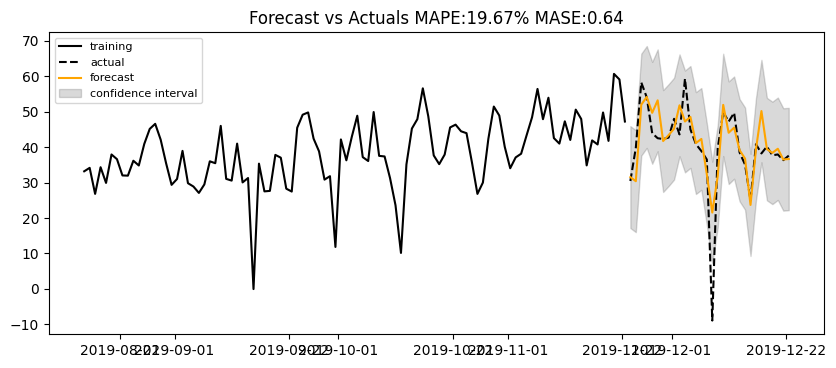

In [105]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

In [106]:
# 2020-09-22 + 30 days
train, test, mape, mase = \
train_sarimax(data=df, split_date = '2020-09-22 11:00:00', 
             exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

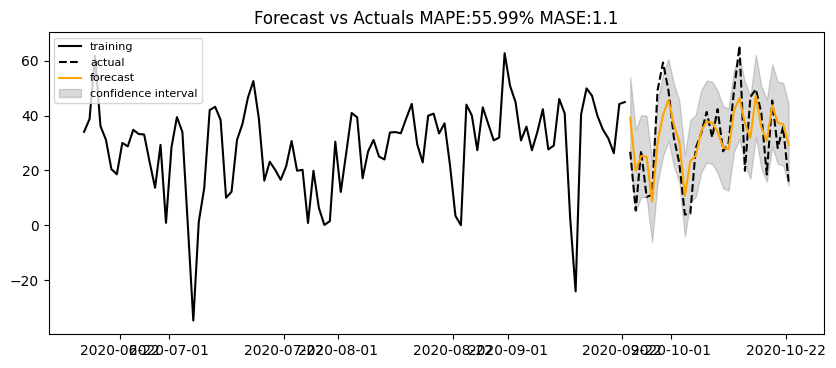

In [107]:
plot_evaluation(train.iloc[-100:], test, mape=mape, mase=mase)

Forecasts for 2020 is not very accurate due to Covid19 caused irregular electricity demand. Need further feature engineering for 2020 forecast.

## Walk forward validation - 6 months

### 2019-08-30 >> 2020-03-01

In [113]:
%%time
# evaluate the sarima model on test_set(2019-8-30 till 2020-03-01, 184 days)
train, test, mape, mase = \
train_sarimax(data=df, split_date = '2019-08-30 11:00:00', n=184,
             exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

################# forecasting for day 120 ##################
################# forecasting for day 121 ##################
################# forecasting for day 122 ##################
################# forecasting for day 123 ##################
################# forecasting for day 124 ##################
################# forecasting for day 125 ##################
################# forecasting for day 126 ##################
################# forecasting for day 127 ##################
################# forecasting for day 128 ##################
################# forecasting for day 129 ##################
################# forecasting for day 130 ##################
################# forecasting for day 131 ##################
################# forecasting for day 132 ##################
################# forecasting for day 133 ##################
################# forecasting for day 134 ##################
################# forecasting for day 135 ##################
################# foreca

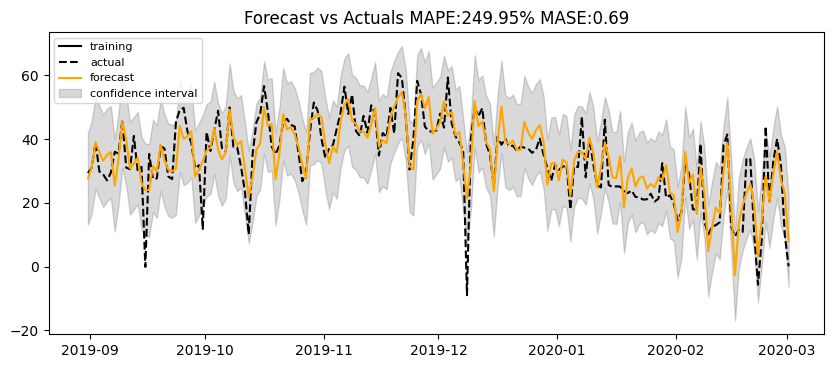

In [115]:
plot_evaluation(train.iloc[-1:], test, mape=mape, mase=mase)

Remove outliers

In [119]:
# checkout the outliers
test[test.price<12]

price  forecast_price  upper_interval  lower_interval
2019-09-15 11:00:00  -0.07       24.102920       38.562628        9.643212
2019-09-30 11:00:00  11.82       33.032943       47.519642       18.546245
2019-10-12 11:00:00  10.13       21.852807       36.350344        7.355269
2019-12-08 11:00:00  -8.96       21.539545       35.907169        7.171922
2020-02-09 11:00:00  10.09        4.897648       19.227226       -9.431930
2020-02-16 11:00:00   9.54       -2.592934       11.719259      -16.905126
2020-02-17 11:00:00  11.60       13.724186       28.046417       -0.598045
2020-02-18 11:00:00  10.91       19.278726       33.595783        4.961669
2020-02-21 11:00:00  10.51       19.424387       33.748955        5.099820
2020-02-22 11:00:00  -5.68        3.211966       17.538689      -11.114756
2020-02-23 11:00:00   8.89       14.607356       28.936171        0.278541
2020-02-29 11:00:00   9.97       23.113414       37.443760        8.783068
2020-03-01 11:00:00   0.10        7.890587       22.230005       -6.448831

In [122]:
# remove the outliers
outliers = test[test.price<12].index[:4]
for outlier in outliers:
    print(test[test.index==outlier])
    test = test.drop(outlier, axis=0)

                     price  forecast_price  upper_interval  lower_interval
2019-09-15 11:00:00  -0.07        24.10292       38.562628        9.643212
                     price  forecast_price  upper_interval  lower_interval
2019-09-30 11:00:00  11.82       33.032943       47.519642       18.546245
                     price  forecast_price  upper_interval  lower_interval
2019-10-12 11:00:00  10.13       21.852807       36.350344        7.355269
                     price  forecast_price  upper_interval  lower_interval
2019-12-08 11:00:00  -8.96       21.539545       35.907169        7.171922


In [124]:
# re-caculate MAPE and MASE after removing the outliers
from electricity_price_predictor.sarima import get_mape, get_mase
mape_clean = get_mape(test.price, test.forecast_price)
mase_clean = get_mase(test.price, test.forecast_price, train.price)
(mape_clean, mase_clean)

('60.12%', '0.64')

Remove Feb data

In [129]:
# remove Feb    
march = test.iloc[-31:].index
for day in march:
    test = test.drop(day, axis=0)

In [130]:
# re-caculate MAPE and MASE after removing Feb data
from electricity_price_predictor.sarima import get_mape, get_mase
mape_clean = get_mape(test.price, test.forecast_price)
mase_clean = get_mase(test.price, test.forecast_price, train.price)
(mape_clean, mase_clean)

('12.35%', '0.6')

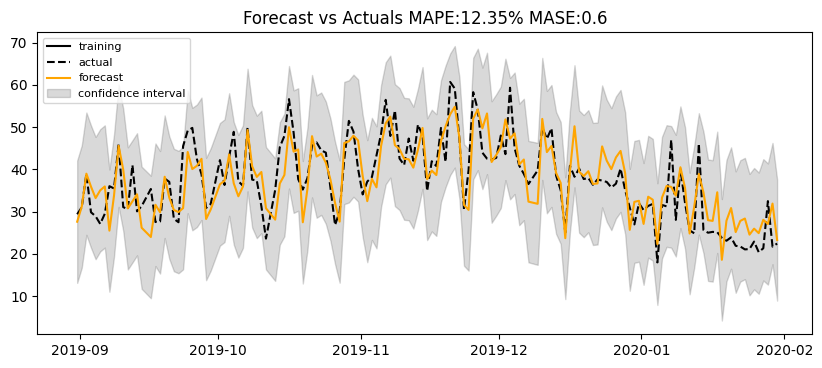

In [131]:
# after removing outliers
plot_evaluation(train.iloc[-1:], test, mape=mape_clean, mase=mase_clean)

### 2019-05-31 >> 2019-11-31

In [132]:
%%time
# evaluate the sarimax model on test_set(2019-5-31 till 2019-11-31, 183 days)
train, test, mape, mase = \
train_sarimax(data=df, split_date = '2019-05-31 11:00:00', n=183,
             exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,1,7)))

################# forecasting for day 1 ##################
################# forecasting for day 2 ##################
################# forecasting for day 3 ##################
################# forecasting for day 4 ##################
################# forecasting for day 5 ##################
################# forecasting for day 6 ##################
################# forecasting for day 7 ##################
################# forecasting for day 8 ##################
################# forecasting for day 9 ##################
################# forecasting for day 10 ##################
################# forecasting for day 11 ##################
################# forecasting for day 12 ##################
################# forecasting for day 13 ##################
################# forecasting for day 14 ##################
################# forecasting for day 15 ##################
################# forecasting for day 16 ##################
################# forecasting for day 17 ########

################# forecasting for day 120 ##################
################# forecasting for day 121 ##################
################# forecasting for day 122 ##################
################# forecasting for day 123 ##################
################# forecasting for day 124 ##################
################# forecasting for day 125 ##################
################# forecasting for day 126 ##################
################# forecasting for day 127 ##################
################# forecasting for day 128 ##################
################# forecasting for day 129 ##################
################# forecasting for day 130 ##################
################# forecasting for day 131 ##################
################# forecasting for day 132 ##################
################# forecasting for day 133 ##################
################# forecasting for day 134 ##################
################# forecasting for day 135 ##################
################# foreca

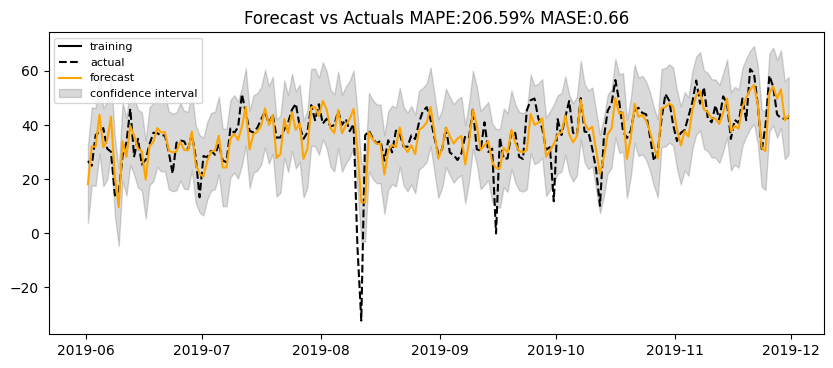

In [134]:
plot_evaluation(train.iloc[-1:], test, mape=mape, mase=mase)

In [144]:
# checkout the outliers
test[(test.price<12) | (test.forecast_price<12)]

price  forecast_price  upper_interval  lower_interval
2019-06-09 11:00:00  14.96        9.684815       24.104379       -4.734749
2019-08-12 11:00:00  36.18       11.350020       25.863414       -3.163375

In [146]:
# remove the outliers
outliers = test[(test.price<12) | (test.forecast_price<12)].index
for outlier in outliers:
    print(test[test.index==outlier])
    test = test.drop(outlier, axis=0)

                     price  forecast_price  upper_interval  lower_interval
2019-06-09 11:00:00  14.96        9.684815       24.104379       -4.734749
                     price  forecast_price  upper_interval  lower_interval
2019-08-12 11:00:00  36.18        11.35002       25.863414       -3.163375


In [147]:
# re-caculate MAPE and MASE after removing the outliers
from electricity_price_predictor.sarima import get_mape, get_mase
mape_clean = get_mape(test.price, test.forecast_price)
mase_clean = get_mase(test.price, test.forecast_price, train.price)
(mape_clean, mase_clean)

('11.37%', '0.56')

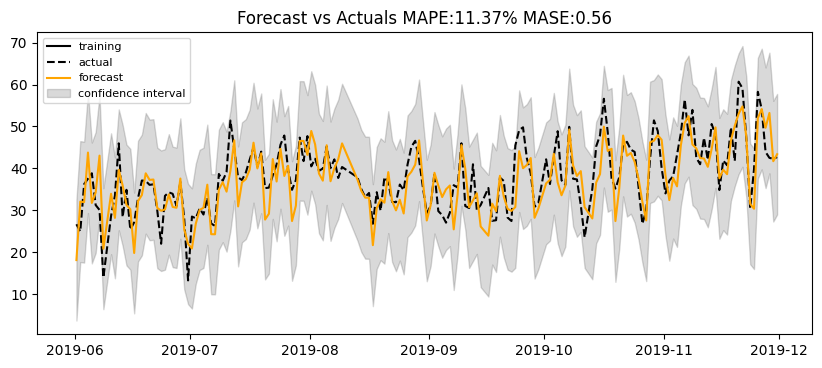

In [148]:
# after removing outliers
plot_evaluation(train.iloc[-1:], test, mape=mape_clean, mase=mase_clean)

# 2days-ahead forecast

- Day-ahead price is updated everday between 12:00-13:00. Therefore, to get 2days-ahead price, call the forecast function after 13:00.

In [149]:
from electricity_price_predictor.sarimax import sarimax_forecast_24
from electricity_price_predictor.data import get_data
from electricity_price_predictor.plot import plot_forecast
from dotenv import load_dotenv
env_path = '../.env'
load_dotenv(dotenv_path=env_path)

True

In [150]:
df = get_data()

In [151]:
forecast, past = sarimax_forecast_24(df=df)

############## forecasting for 1:00 o'clock ##############
############## forecasting for 2:00 o'clock ##############
############## forecasting for 3:00 o'clock ##############
############## forecasting for 4:00 o'clock ##############
############## forecasting for 5:00 o'clock ##############
############## forecasting for 6:00 o'clock ##############
############## forecasting for 7:00 o'clock ##############
############## forecasting for 8:00 o'clock ##############
############## forecasting for 9:00 o'clock ##############
############## forecasting for 10:00 o'clock ##############
############## forecasting for 11:00 o'clock ##############
############## forecasting for 12:00 o'clock ##############
############## forecasting for 13:00 o'clock ##############
############## forecasting for 14:00 o'clock ##############
############## forecasting for 15:00 o'clock ##############
############## forecasting for 16:00 o'clock ##############
############## forecasting for 17:00 o'clock ####

############## saving forecast plot ##############


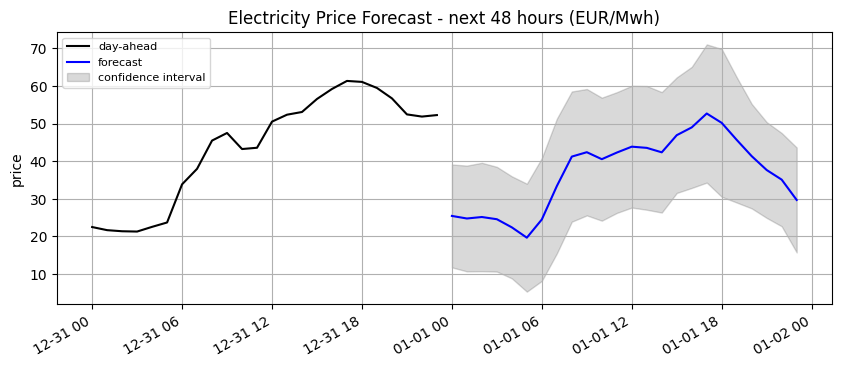

In [152]:
plot_forecast(forecast, past)